In [1]:
import os
import sys
import time

import torch.nn as nn
import torch.nn.init as init

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
#Loading Pretrained model
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(model.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
#Replacing the output layer and freezing all the hidden layers excluding the replaced output layer
model.fc = nn.Linear(512, 10)
for param in model.parameters(): 
  param.requires_grad = False
for param in model.fc.parameters(): 
  param.requires_grad = True


In [ ]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
print(model.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [4]:
#Defining Transformations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


==> Preparing data..


In [5]:
#Loading Dataset and DataLoader
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)


trainset,validationset=torch.utils.data.random_split(trainset,[40000,10000])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=60, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(
    validationset, batch_size=60, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Defining instance of ResNet18 model, Loss function, Optimizer and Scheduler
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [6]:
TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [37]:
# Training
loss_train=[]
loss_test=[]
train_loss = 0
test_loss=0
def train(net,epoch):
    
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    loss_train.append(train_loss)


def test(net,epoch):
    
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validationloader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(validationloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    loss_test.append(test_loss)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


In [ ]:
for epoch in range(start_epoch, start_epoch+15):
    train(model,epoch)
    test(model,epoch)
    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 60ms | Tot: 1m22s | Loss: 1.109 | Acc: 65.180% (26072/40000)
 [================================================================>]  Step: 69ms | Tot: 19s939ms | Loss: 0.827 | Acc: 73.070% (7307/10000)

Epoch: 1
 [================================================================>]  Step: 64ms | Tot: 1m21s | Loss: 0.779 | Acc: 74.125% (29650/40000)
 [================================================================>]  Step: 63ms | Tot: 19s961ms | Loss: 0.736 | Acc: 75.290% (7529/10000)

Epoch: 2
 [================================================================>]  Step: 63ms | Tot: 1m22s | Loss: 0.726 | Acc: 75.578% (30231/40000)
 [================================================================>]  Step: 52ms | Tot: 19s949ms | Loss: 0.700 | Acc: 76.740% (7674/10000)

Epoch: 3
 [================================================================>]  Step: 67ms | Tot: 1m22s | Loss: 0.699 | Acc: 76.180% (30472/40

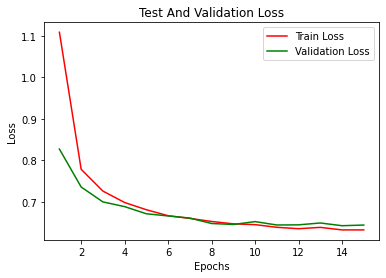

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train), len(loss_train))
y=loss_train
y=np.array(y)
y/=len(trainloader)
z=loss_test
z=np.array(z)
z/=len(validationloader)

plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Validation Loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test And Validation Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'checkpoint0.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model, path)

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.7 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 69.2 %
Accuracy for class: cat   is 65.2 %
Accuracy for class: deer  is 74.5 %
Accuracy for class: dog   is 76.5 %
Accuracy for class: frog  is 83.3 %
Accuracy for class: horse is 76.9 %
Accuracy for class: ship  is 82.9 %
Accuracy for class: truck is 83.6 %


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 77 %


In [15]:
model_save_name = 'checkpoint0.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model1 = torch.load(path)

In [ ]:
model1 = torch.load()

In [ ]:
print(model1.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
print(model1.layer4.parameters)

<bound method Module.parameters of Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [16]:
#Unfreezing layer 4
for param in model1.parameters(): 
  param.requires_grad = False
for param in model1.fc.parameters(): 
  param.requires_grad = True
for param in model1.layer4.parameters():
  param.requires_grad = True

In [17]:
#Defining Loss function, Optimizer and Scheduler
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [18]:
for epoch in range(start_epoch, start_epoch+15):
    train(model1,epoch)
    test(model1,epoch)
    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 71ms | Tot: 1m27s | Loss: 0.491 | Acc: 82.888% (33155/40000)
 [================================================================>]  Step: 63ms | Tot: 20s618ms | Loss: 0.398 | Acc: 86.210% (8621/10000)

Epoch: 1
 [================================================================>]  Step: 75ms | Tot: 1m27s | Loss: 0.290 | Acc: 90.235% (36094/40000)
 [================================================================>]  Step: 55ms | Tot: 20s693ms | Loss: 0.352 | Acc: 87.660% (8766/10000)

Epoch: 2
 [================================================================>]  Step: 76ms | Tot: 1m27s | Loss: 0.196 | Acc: 93.632% (37453/40000)
 [================================================================>]  Step: 67ms | Tot: 20s725ms | Loss: 0.333 | Acc: 88.600% (8860/10000)

Epoch: 3
 [================================================================>]  Step: 79ms | Tot: 1m27s | Loss: 0.135 | Acc: 95.978% (38391/40

In [30]:
seq1loss_train=np.array(loss_train[15:])/len(trainloader)
seq1loss_test=np.array(loss_test[15:])/len(validationloader)

In [32]:
print(seq1loss_test)

[0.39757563 0.35162565 0.33257118 0.32742058 0.3247916  0.32827869
 0.33341151 0.33653984 0.33884539 0.33823566 0.34289371 0.34167735
 0.33897337 0.33909677 0.34196826]


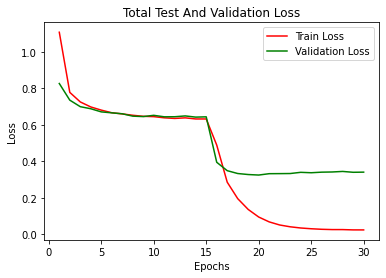

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train), len(loss_train))
y=loss_train
y=np.array(y)
y/=len(trainloader)
z=loss_test
z=np.array(z)
z/=len(validationloader)

plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Validation Loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Test And Validation Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

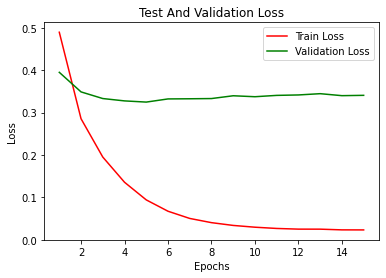

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train[15:]), len(loss_train[15:]))
y=loss_train[15:]
y=np.array(y)
y/=len(trainloader)
z=loss_test[15:]
z=np.array(z)
z/=len(validationloader)

plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Validation Loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test And Validation Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [ ]:
model_save_name = 'checkpoint1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model1, path)

In [ ]:
#Testing Test Set
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)

        outputs = model1(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 89.11 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)

        outputs = model1(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 90.8 %
Accuracy for class: car   is 94.2 %
Accuracy for class: bird  is 87.5 %
Accuracy for class: cat   is 78.8 %
Accuracy for class: deer  is 87.1 %
Accuracy for class: dog   is 84.6 %
Accuracy for class: frog  is 92.0 %
Accuracy for class: horse is 90.7 %
Accuracy for class: ship  is 93.8 %
Accuracy for class: truck is 91.6 %


In [ ]:
model_save_name = 'checkpoint1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model2 = torch.load(path)

In [ ]:
#Unfreezing layer 3
for param in model2.parameters(): 
  param.requires_grad = False
for param in model2.fc.parameters(): 
  param.requires_grad = True
for param in model2.layer4.parameters():
  param.requires_grad = True
for param in model2.layer3.parameters():
  param.requires_grad = True

In [ ]:
print(model2.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
#Defining Loss function, Optimizer and Scheduler
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [ ]:
for epoch in range(start_epoch, start_epoch+15):
    train(model2,epoch)
    test(model2,epoch)
    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 89ms | Tot: 1m37s | Loss: 0.025 | Acc: 99.760% (39904/40000)
 [================================================================>]  Step: 55ms | Tot: 21s927ms | Loss: 0.337 | Acc: 90.170% (9017/10000)
Saving..

Epoch: 1
 [================================================================>]  Step: 89ms | Tot: 1m38s | Loss: 0.018 | Acc: 99.830% (39932/40000)
 [================================================================>]  Step: 68ms | Tot: 21s724ms | Loss: 0.334 | Acc: 90.370% (9037/10000)
Saving..

Epoch: 2
 [================================================================>]  Step: 88ms | Tot: 1m37s | Loss: 0.014 | Acc: 99.897% (39959/40000)
 [================================================================>]  Step: 67ms | Tot: 21s737ms | Loss: 0.334 | Acc: 90.210% (9021/10000)

Epoch: 3
 [================================================================>]  Step: 90ms | Tot: 1m37s | Loss: 0.011 | Acc:

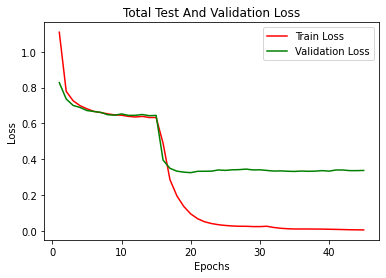

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train), len(loss_train))
y=loss_train
y=np.array(y)
y/=len(trainloader)
z=loss_test
z=np.array(z)
z/=len(validationloader)

plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Validation Loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Test And Validation Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

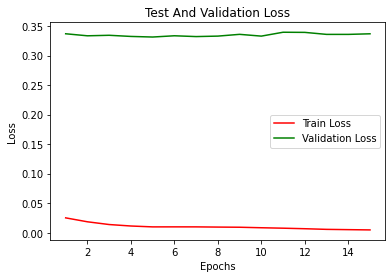

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train[30:]), len(loss_train[30:]))
y=loss_train[30:]
y=np.array(y)
y/=len(trainloader)
z=loss_test[30:]
z=np.array(z)
z/=len(validationloader)

plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Validation Loss')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test And Validation Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [ ]:
model_save_name = 'checkpoint2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model2, path)

In [ ]:
#Testing Test Set
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)

        outputs = model2(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 89.94 %


In [8]:
model3=torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model3.fc = nn.Linear(512, 10)
for param in model3.parameters(): 
  param.requires_grad = False
for param in model3.fc.parameters(): 
  param.requires_grad = True
for param in model3.layer4.parameters():
  param.requires_grad = True
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
for epoch in range(start_epoch, start_epoch+15):
    train(model3,epoch)
    test(model3,epoch)
    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 74ms | Tot: 1m24s | Loss: 0.745 | Acc: 75.585% (30234/40000)
 [================================================================>]  Step: 54ms | Tot: 22s311ms | Loss: 0.445 | Acc: 84.920% (8492/10000)
Saving..

Epoch: 1
 [================================================================>]  Step: 76ms | Tot: 1m26s | Loss: 0.388 | Acc: 86.907% (34763/40000)
 [================================================================>]  Step: 65ms | Tot: 20s974ms | Loss: 0.377 | Acc: 87.210% (8721/10000)
Saving..

Epoch: 2
 [================================================================>]  Step: 75ms | Tot: 1m27s | Loss: 0.289 | Acc: 90.115% (36046/40000)
 [================================================================>]  Step: 49ms | Tot: 20s854ms | Loss: 0.342 | Acc: 88.310% (8831/10000)
Saving..

Epoch: 3
 [================================================================>]  Step: 78ms | Tot: 1m26s | Loss: 0.2

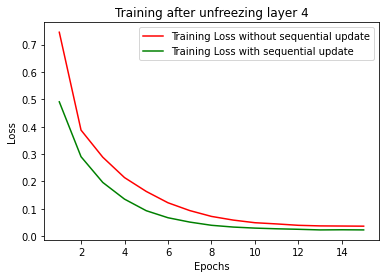

In [35]:
import matplotlib.pyplot as plt
import numpy as np

X=np.linspace(1, len(loss_train[:15]), len(loss_train[:15]))
y=loss_train[:15]
y=np.array(y)
y/=len(trainloader)
z=seq1loss_train
plt.plot(X, y, color='r', label='Training Loss without sequential update')
plt.plot(X, z, color='g', label='Training Loss with sequential update')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training after unfreezing layer 4")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()
#HERE IT IS CLEAR THAT TILL THE BEST CONVERGENCE IN TRAIN LOSS, SEQUENTIAL UPDATE IS FASTER

In [38]:
model_save_name = 'checkpoint3.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model3, path)